# Part 1

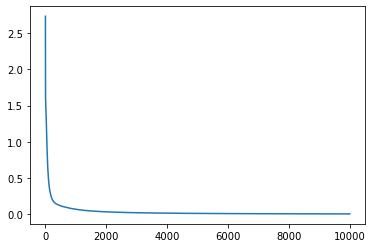

In [1]:
import numpy as np
from scripts import NN
from matplotlib import pyplot as plt

# Train autoencoder
autoencoder = NN.NeuralNetwork(8,3,8)
identity_matrix = np.array([[1,0,0,0,0,0,0,0],
                           [0,1,0,0,0,0,0,0],
                           [0,0,1,0,0,0,0,0],
                           [0,0,0,1,0,0,0,0],
                           [0,0,0,0,1,0,0,0],
                           [0,0,0,0,0,1,0,0],
                           [0,0,0,0,0,0,1,0],
                           [0,0,0,0,0,0,0,1]])
autoencoder.train(identity_matrix, identity_matrix, batch_size=4, num_epochs=10000, learning_rate=2)
autoencoder.epoch_losses
plt.plot(autoencoder.epoch_losses)

In [2]:
# Get outputs for trained autoencoder

outputs = autoencoder.predict(identity_matrix)
np.set_printoptions(suppress=True)
outputs

array([[0.99758326, 0.0005506 , 0.00060786, 0.00099432, 0.00058822,
        0.        , 0.        , 0.        ],
       [0.00006573, 0.99697292, 0.        , 0.        , 0.00024709,
        0.00040556, 0.        , 0.00044117],
       [0.0002548 , 0.        , 0.99054983, 0.00585186, 0.00000165,
        0.00000001, 0.00309074, 0.        ],
       [0.00134197, 0.00000023, 0.00424207, 0.99042177, 0.        ,
        0.00506657, 0.        , 0.        ],
       [0.00176942, 0.00141839, 0.00000156, 0.        , 0.99835849,
        0.        , 0.00100245, 0.00000016],
       [0.00000018, 0.0007285 , 0.        , 0.00437635, 0.        ,
        0.99184552, 0.        , 0.00231863],
       [0.00000004, 0.00000006, 0.0045079 , 0.        , 0.00107816,
        0.        , 0.99343359, 0.00363395],
       [0.        , 0.00168363, 0.        , 0.        , 0.00000263,
        0.00442327, 0.00188964, 0.99431053]])

# Part 2

2a. To encode DNA sequences, I implemented one hot encoding. Each of the four DNA nucleotides is mapped to a unique 4-bit array. For example, "A" maps to [1,0,0,0]. This yields a 2D array (dimensions: len(seq)x4) where each row is the 4-bit array representing each nucleotide. Then the array is flattened to yield a 1D array where every 4 values represents one nucleotide from the original sequence. A 17-mer would be encoded as a 68-length binary array. I think this representation will not affect the network's predictions because there is no implied similarity or dissimilarity between any of the four encodings. For example, an alternate encoding would be to map A, T, C, G to 1, 2, 3, 4, respectively. This would inadvertantly imply more similarity between A and T than between A and G (1 is closer to 1 than to 4).

3a. For my training regime, I decided to use all of the examples from the positive training data, and to subsample examples from the negative training data. I made a function, sample_subseqs(), that can take in the negative training data, and do random sampling to get a specified number of subsequences of specified length. For example, it could get 137 subsequences of length 17. The function can also take in a np.array of sequences that should be excluded from the returned subsequences, so I can input in the positive examples to that argument to ensure that none of the positive examples coincidentally show up in the negative examples too. For my training regime, to prevent the negative training data from overwhelming the positive training data, I decided to build to do a 1:1 ratio of positive:negative data. Therefore, I will use my sample_subseqs() function to generate 137 17mers from the negative data, and ensure that none of those 17mers also show up in the positive data.

In [3]:
import numpy as np
from scripts import NN

# Read in sequences, subsample negative data, and do encoding
pos_seqs = NN.read_fasta("data/rap1-lieb-positives.txt")
neg_seqs_all = NN.read_fasta("data/yeast-upstream-1k-negative.fa")
neg_seqs = NN.sample_subseqs(neg_seqs_all, 17, 137, pos_seqs)
pos = NN.encode(pos_seqs)
neg = NN.encode(neg_seqs)
pos_out = np.ones(shape=(137, 1))
neg_out = np.zeros(shape=(137, 1))

# Combine & shuffle data for training
all_in_out = np.column_stack((np.row_stack((pos, neg)), np.row_stack((pos_out, neg_out))))
np.random.seed(0)
np.random.shuffle(all_in_out)

In [4]:
# Do training
part2_nn = NN.NeuralNetwork(68, 50, 1)
part2_nn.train(all_in_out[:,0:68], all_in_out[:,68:69])

array([0.00000861, 0.0000086 , 0.00000859])

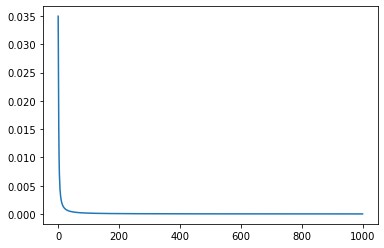

In [5]:
from matplotlib import pyplot as plt

# Visualize losses
plt.plot(part2_nn.epoch_losses)

# Get the last few losses
np.set_printoptions(suppress=True)
part2_nn.epoch_losses[-4:-1]

In [6]:
from sklearn.metrics import roc_auc_score

# Evaluate this initial model just using all the training data
part2_preds = part2_nn.predict(all_in_out[:,0:68])
part2_auc = roc_auc_score(all_in_out[:,68:69], part2_preds)
part2_auc

1.0

In [7]:
# 4a

# Positive example (the 0th sequence from the positive data file)
print("Positive sequence:")
print(pos_seqs[0])
print("Input for positive sequence:")
print(pos[0])
print("Output for positive sequence:")
pos_example_out = part2_nn.predict(pos[0])
print(pos_example_out)

# Negative example (the 0th sequence from the negative data file)
print("Negative sequence:")
print(neg_seqs[0])
print("Input for negative sequence:")
print(neg[0])
print("Output for negative sequence:")
neg_example_out = part2_nn.predict(neg[0])
np.set_printoptions(suppress=True)
print(neg_example_out)

Positive sequence:
ACATCCGTGCACCTCCG
Input for positive sequence:
[1 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 1 0
 0 1 0 1 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 1]
Output for positive sequence:
[[0.9999979]]
Negative sequence:
CACTACCACAGAGGGGC
Input for negative sequence:
[0 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 1 0 1
 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 1 0]
Output for negative sequence:
[[0.00000001]]


4b. For my network architecture, I used a 3-layer network with an input layer size 68, hidden layer size 50, and output layer size 1. The hyperparameters used were the defaults that I had set in my code. They are: batch size 10, 1000 epochs, learning rate 0.1, and loss threshold 0.00000000001. My training data had a random shuffled order of positive and negative data, to ensure that batches were unlikely to be entirely positive data or entirely negative data. The results of my training looked promising. My ROC AUC was 1.0, which is very good. This should be taken with a grain of salt though because the model was trained on all the data, and then tested on the very same data. In terms of minimizing error, the model seemed to perform well. As illustrated in the plot above, the loss decreased over the course of the training and the average loss for the final epoch was 0.00000859.

4c. My stop criteria for convergence of my learned parameters was: the average loss per epoch starts increasing and the average loss per epoch has dropped below a user-specified loss threshold. I decided on the former criterion because if loss increases, it indicates that the model is probably no longer improving. It is possible that the model is in a local minimum, which is why I also included the latter criterion. If the loss is below the threshold, even if the model is possibly in a local minimum, any further improvements are relatively inconsequential.

# Part 3

In [43]:
# Split data into 10 folds
folds = np.array_split(all_in_out, 10)

# Function to do 10fold cross validation
# h = num nodes in hidden layer, b = batch size, e = num epochs, l = learning rate
def cv(h, b, e, l):
    # List of aucs for each fold
    aucs = []
    # Go through each fold
    for i in range(10):
        # Make neural network
        nn = NN.NeuralNetwork(68, h, 1)
        # Split into training and validation data
        training_data = np.row_stack(folds[0:i] + folds[i:10])
        validation_data = folds[i]
        # Do training
        nn.train(training_data[:,0:68], training_data[:,68:69], b, e, l)
        # Do classification
        preds = nn.predict(validation_data[:,0:68])
        # Do evaluation
        auc = roc_auc_score(validation_data[:,68:69], preds)
        aucs.append(auc)
    # Return aucs
    return aucs

# Do cv
part3_aucs = cv(50, 10, 1000, 0.1)

In [42]:
print("AUC for each fold from 10-fold cross validation:")
part3_aucs

AUC for each fold from 10-fold cross validation:


[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

5a. I can use k-fold cross validation to determine my model's performance by splitting my data into folds, holding one out as validation data, and then using the rest as training data. Then I can compute a ROC AUC for the results from the validaion set for each fold.

5b. I selected the value of k to be 10. For kfold cross validation, common values of k are 5, 10, and 20. I picked 10 because it's a reasonable middle ground and would result in folds containing around 27 sequences each. This seemed like a big enough fold size that the fold AUC would be informative, but also small enough that it would sufficiently capture any variance or stochasticity in the dataset.

5c. The relevant metric of performance for each fold that I chose was ROC AUC because that's a good performance metric for a classification problem, which this problem is. My model performed well. All of the AUCs were 1.0, which is the highest possible value for an AUC.

# Part 4

For this section, I've decided to do a few rounds of grid search to optimize the hyperparameters. I'm trying out different combinations of: the number of nodes in the hidden layer, the batch size, the number of epochs, and the learning rate. To assess performance, I use AUC from 10fold cross validation.

In [79]:
# Make a list containing the results of the first grid search
# where the 0th column is the number of nodes in the hidden layer,
# the 1st column is the batch size, the 2nd column is the number
# of epochs, the 3rd column is the learning rate, and the 4th
# column is the average fold auc for the CV of that combo of
# hyperparameters
gs1 = []

# Do the grid search
for h in [20,50]: # size of hidden layer
    for b in [10,20]: # batch size
        for e in [10,100]: # number of epochs
            for l in [0.1,1,2]: # learning rate
                aucs = cv(h, b, e, l)
                gs1.append((h, b, e, l, np.mean(aucs)))

In [80]:
print("hidden layer size, batch size, num epochs, learning rate, avg fold auc")
gs1

hidden layer size, batch size, num epochs, learning rate, avg fold auc


[(20, 10, 10, 0.1, 1.0),
 (20, 10, 10, 1, 1.0),
 (20, 10, 10, 2, 1.0),
 (20, 10, 100, 0.1, 1.0),
 (20, 10, 100, 1, 1.0),
 (20, 10, 100, 2, 1.0),
 (20, 20, 10, 0.1, 1.0),
 (20, 20, 10, 1, 1.0),
 (20, 20, 10, 2, 0.36832188469793514),
 (20, 20, 100, 0.1, 1.0),
 (20, 20, 100, 1, 1.0),
 (20, 20, 100, 2, 0.36832188469793514),
 (50, 10, 10, 0.1, 1.0),
 (50, 10, 10, 1, 0.15326195279976793),
 (50, 10, 10, 2, 0.09606597184328276),
 (50, 10, 100, 0.1, 1.0),
 (50, 10, 100, 1, 0.15326195279976793),
 (50, 10, 100, 2, 0.09606597184328276),
 (50, 20, 10, 0.1, 1.0),
 (50, 20, 10, 1, 0.08376781248629989),
 (50, 20, 10, 2, 0.18900560224089638),
 (50, 20, 100, 0.1, 1.0),
 (50, 20, 100, 1, 0.08376781248629989),
 (50, 20, 100, 2, 0.18900560224089638)]

Based on the above results, the lower learning rate (0.1) performed better than the higher learning rates (1 and 2). For the next round of grid search, I'm going to keep the learning rate at 0.1, and focus more on the size of the hidden layer and the batch size.

In [81]:
gs2 = []
for h in [20,40,60]: # size of hidden layer
    for b in [10,20,30]: # batch size
        for e in [10,100]: # number of epochs
            aucs = cv(h, b, e, 0.1)
            gs2.append((h, b, e, np.mean(aucs)))

In [82]:
print("hidden layer size, batch size, num epochs, avg fold auc")
gs2

hidden layer size, batch size, num epochs, avg fold auc


[(20, 10, 10, 1.0),
 (20, 10, 100, 1.0),
 (20, 20, 10, 1.0),
 (20, 20, 100, 1.0),
 (20, 30, 10, 1.0),
 (20, 30, 100, 1.0),
 (40, 10, 10, 1.0),
 (40, 10, 100, 1.0),
 (40, 20, 10, 1.0),
 (40, 20, 100, 1.0),
 (40, 30, 10, 1.0),
 (40, 30, 100, 1.0),
 (60, 10, 10, 1.0),
 (60, 10, 100, 1.0),
 (60, 20, 10, 1.0),
 (60, 20, 100, 1.0),
 (60, 30, 10, 1.0),
 (60, 30, 100, 1.0)]

For this round, all of the AUCs were 1.0, so I'm going to try "up the stakes" for the next round to get a better sense of which hyperparameter values work better. To "up the stakes", I will lower the number of epochs to 5. I'm less concerned with tuning that parameter than the other ones, because I assume that generally speaking, a higher number of epochs will yield better performance than a lower number of epochs.

In [83]:
gs3 = []
for h in [20,40,60]: # size of hidden layer
    for b in [10,20,30]: # batch size
        aucs = cv(h, b, 5, 0.1)
        gs3.append((h, b, np.mean(aucs)))

In [85]:
print("hidden layer size, batch size, avg fold auc")
gs3

hidden layer size, batch size, avg fold auc


[(20, 10, 1.0),
 (20, 20, 1.0),
 (20, 30, 1.0),
 (40, 10, 1.0),
 (40, 20, 1.0),
 (40, 30, 1.0),
 (60, 10, 1.0),
 (60, 20, 1.0),
 (60, 30, 1.0)]

Ok, challenge accepted. Let's try 1 epoch.

In [88]:
gs4 = []
for h in [20,40,60]: # size of hidden layer
    for b in [10,20,30]: # batch size
        aucs = cv(h, b, 1, 0.1)
        gs4.append((h, b, np.mean(aucs)))
print("hidden layer size, batch size, avg fold auc")
gs4

hidden layer size, batch size, avg fold auc


[(20, 10, 1.0),
 (20, 20, 1.0),
 (20, 30, 1.0),
 (40, 10, 1.0),
 (40, 20, 0.9994444444444444),
 (40, 30, 1.0),
 (60, 10, 1.0),
 (60, 20, 1.0),
 (60, 30, 1.0)]

This is kind of a challenging result to interpret. The only non-1 AUC was the combo with the middle values for hidden layer size & batch size, so it's hard to tell if the model performed better with increasing or decreasing those values. I will try turn up the heat even more by increasing the learning rate back to 1 and see what happens with the hidden layer size & batch size.

In [90]:
gs5 = []
for h in [20,40,60]: # size of hidden layer
    for b in [10,20,30]: # batch size
        aucs = cv(h, b, 1, 1)
        gs5.append((h, b, np.mean(aucs)))
print("hidden layer size, batch size, avg fold auc")
gs5

hidden layer size, batch size, avg fold auc


[(20, 10, 1.0),
 (20, 20, 0.9963426909225228),
 (20, 30, 0.3156079016688261),
 (40, 10, 0.7555400715064581),
 (40, 20, 0.7253677088551038),
 (40, 30, 0.7370906940864923),
 (60, 10, 0.2733460971801308),
 (60, 20, 0.2851477339187423),
 (60, 30, 0.2852316521014)]

Yay! A trend! It seems that smaller hidden layer sizes (20) are better than bigger hidden layer sizes (60). It seems that smaller batch sizes work better when the hidden layer size is smaller and larger batch sizes work better when the hidden layer size is larger. Moving forward, I think I will do a hidden layer size of 20 and batch size of 10. Lastly, I will tune the number of epochs.

In [91]:
gs6 = []
for e in [100,1000]: # size of hidden layer
    aucs = cv(20, 10, e, 1)
    gs6.append((e, np.mean(aucs)))
print("num epochs, avg fold auc")
gs6

num epochs, avg fold auc


[(100, 1.0), (1000, 1.0)]

Well, both had an AUC of 1. I think more epochs is a safer bet than fewer epochs. Overall, the set of learning parameters that works the best is: hidden layer size of 20, batch size of 10, learning rate of 0.1, and number of epochs of 1000. Sample outputs from my system for optimization are above (the 6 rounds of grid search). The effects of altering my system depended on the hyperparameter. More epochs yielded better results. This is unsurprising and I think we observe these effects because it gives the model "more chances" to learn the data and get it right. The model seemed to work best for low values for: hidden layer size, batch size, and learning rate. This result was somewhat surprising for hidden layer size, as I had assumed a bigger hidden layer would be better. I think that's mostly because I read some random rule of thumb on the internet that the hidden layer should be roughly 2/3 the size of the input layer. But I guess I shouldn't always believe everything I read on the internet. Also it's possible the results of my optimization are wrong. Due to time/memory constraints, I couldn't do a huge grid search of lots of hyperparameter values at once, so I did the process in 6 rounds, making changes here and there. It's possible that the ideal hyperparameter combo is a combo that I didn't cover with my grid search. It seems reasonable that a smaller batch size was better. This would let the model slowly learn the data bit by bit, instead of in enormous chunks. Also it makes sense that a smaller learning rate was better. This would ensure the model didn't update weights to quickly or dramatically, and my number of epochs is pretty big (1000), so that's plenty of time to learn. Other parameters that may affect performance are the choice of activation function, although I'm under the impression that sigmoid is a reasonable/standard activation function for these types of problems. Also, perhaps a different number of hidden layers would impact the performance, but my implementation doesn't allow for that.

# Part 5

6a. For my final model, I will use a 68x20x1 network with batch size 10, learning rate 0.1, and 1000 epochs.

In [96]:
# 6b

# Train network on all the data
part6_nn = NN.NeuralNetwork(68, 20, 1)
part6_nn.train(all_in_out[:,0:68], all_in_out[:,68:69], 10, 1000, 0.1)

In [97]:
# Run on test data
test_seqs = NN.read_fasta("data/rap1-lieb-test.txt")
test = NN.encode(test_seqs)
test_preds = part6_nn.predict(test)
test_preds

array([[0.00110013],
       [0.7176767 ],
       [0.999956  ],
       ...,
       [0.00678338],
       [0.00754665],
       [0.1749296 ]])

In [100]:
# Format output for outfile
test_seqs_preds = np.column_stack((test_seqs, test_preds))
test_seqs_preds

array([['AAAAAAACGCAACTAAT', '0.0011001348624881265'],
       ['AAAAACACACATCTGGC', '0.7176767007066459'],
       ['AAAACCAAACACCTGAA', '0.9999559968237722'],
       ...,
       ['TTTCTCATACACCTTTA', '0.0067833792550472125'],
       ['TTTTCCAAGCATTTGTA', '0.007546651164360559'],
       ['TTTTCCATACCTTCCTT', '0.17492960103400187']], dtype='<U32')

In [102]:
# Write to outfile
np.savetxt("part5-results.tsv", test_seqs_preds, fmt='%s', delimiter="\t")

TypeError: Mismatch between array dtype ('<U32') and format specifier ('%.18e	%.18e')